#Capstone Project: Best College Towns

##Introduction

As a web-based service that assists students in selecting schools, we accept requests from prospective high school students to compare colleges and universities along a variety of factors.  As high school students prepare to apply to colleges, they want to consider their college experience.  What type of college town are their target schools based in? They can't afford to visit all.  Therefore, we will leverage the Foursquare API and develop a K-means clustering to get some sense of what types of environments exist and how similar different schools are.  

We receive a request from a students with the schools they are interested in.  The ten schools the student is considering are: Northwestern University (Evanston, Illinois); University of Michigan (Ann Arbor, Michigan); Stanford (Palo Alto, California); Auburn (Auburn, Alabama); Florida State (Talllahasse, Florida); Wellesley College (Wellesley, Massachusetts); Tufts (Medford, Massachusetts); Columbia University (New York City, New York); Duke University (Durham, North Carolina); Washington University (St. Louis, Missouris).

##Data

We will use the Foursquare API and the school address to pull the top venues around with a 1 kilometer radius of the school, easily within walking distance.  The Foursquare data is regularly updated, high quality data set for understanding the types of venues that exist whether it be coffee shops, bars, or parks.  To use this data, we will take the school addresses and use the geopy.goecoders package to convert them into latitudes and longitudes for each school.  We will then retrieve the nearby venues from the API.  

In [1]:
import numpy as np
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
geopy                     1.19.0                     py_0    conda-forge
Fetching package metadata .............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /opt/conda/envs/DSX-Python35:
#
folium                    0.5.0                      py_0    conda-forge
Libraries imported.


##Get and Transform Data
Import a csv file containing the names of the 10 schools and their addresses.

In [2]:
path='https://raw.githubusercontent.com/caradschmidt/Coursera_Capstone/master/top10.csv'
df = pd.read_csv(path)
df

,School,Address
0,Northwestern University,"633 Clark St, Evanston, IL 60208"
1,University of Michigan,"500 S State St, Ann Arbor, MI 48109"
2,Stanford University,"450 Serra Mall, Stanford, CA 94305"
3,Auburn University,"Quad Center, Auburn, AL 36849"
4,Florida State,"600 W College Ave, Tallahassee, FL 32306"
5,Wellesley College,"106 Central St, Wellesley, MA 02481"
6,Tufts University,"419 Boston Ave, Medford, MA 02155"
7,Columbia University,"1130 Amsterdam Avenue New York, NY 10027"
8,Duke University,"2138 Campus Drive Durham, NC 27708"
9,Washington University,"1 Brookings Dr, St. Louis, MO 63130"


Use the addresses to get the geocoordinates using the geopy package.

In [3]:
geolocator = Nominatim(user_agent="college_explorer")
df['Latitude'] = df['Address'].apply(geolocator.geocode).apply(lambda x: (x.latitude))
df['Longitude'] = df['Address'].apply(geolocator.geocode).apply(lambda x: (x.longitude))
df=df.drop(['Address'], axis=1)
df

,School,Latitude,Longitude
0,Northwestern University,42.050504,-87.679817
1,University of Michigan,42.277745,-83.735939
2,Stanford University,37.428636,-122.168118
3,Auburn University,32.602405,-85.484832
4,Florida State,30.442360,-84.297479
5,Wellesley College,42.293741,-71.307343
6,Tufts University,42.408575,-71.118368
7,Columbia University,40.806662,-73.960228
8,Duke University,35.999719,-78.933288
9,Washington University,38.647128,-90.302661


In [4]:
latitude = df['Latitude']
longitude = df['Longitude']

Create a map of the schools to ensure the data is accurate.

In [5]:
map_colleges = folium.Map(location=[38, -98], zoom_start=4)

for lat, lon, poi in zip(df['Latitude'], df['Longitude'], df['School']):
    label = folium.Popup(str(poi))
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="blue",
        fill=True,
        fill_color="blue",
        fill_opacity=0.7,
        parse_html=False).add_to(map_colleges)
       
map_colleges

## Pull Nearby Venues from Foursquare API

In [6]:
CLIENT_ID = 'QHLMSMIBOPEMVOAFYBJEL2VELAUSY1DKHTKA553RG31M3K5O' # your Foursquare ID
CLIENT_SECRET = 'BMIG2AEDMOUHPJSDJLU4F1CMJAW5HHOQVL5Z4HMHL1V0UKLL' # your Foursquare Secret
VERSION = '20190401' # Foursquare API version

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['School', 
                  'School Latitude', 
                  'School Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
LIMIT=100
college_venues = getNearbyVenues(names=df['School'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Northwestern University
University of Michigan
Stanford University
Auburn University
Florida State
Wellesley College 
Tufts University
Columbia University
Duke University
Washington University


In [9]:
print(college_venues.shape)
college_venues.head()

(689, 7)


,School,School Latitude,School Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Northwestern University,42.050504,-87.679817,Blaze Pizza,42.049606,-87.681572,Pizza Place
1,Northwestern University,42.050504,-87.679817,Andy's Frozen Custard,42.048470,-87.681512,Ice Cream Shop
2,Northwestern University,42.050504,-87.679817,Evanston Public Library,42.048260,-87.679929,Library
3,Northwestern University,42.050504,-87.679817,Evanston Athletic Club,42.049375,-87.683101,Gym
4,Northwestern University,42.050504,-87.679817,Lou Malnati's Pizzeria,42.051383,-87.681848,Pizza Place


This shows how many venues were pulled for each school.  From this you can see taht Wellesey and Duke have significantly less than the other schools.

In [10]:
count=college_venues.groupby('School').count()

In [11]:
count=count.reset_index()
count=count[['School', 'Venue']]
count

,School,Venue
0,Auburn University,83
1,Columbia University,100
2,Duke University,28
3,Florida State,80
4,Northwestern University,95
5,Stanford University,60
6,Tufts University,58
7,University of Michigan,100
8,Washington University,64
9,Wellesley College,21


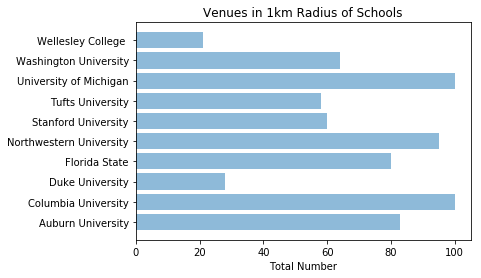

In [12]:
objects = count['School']
y_pos = np.arange(len(objects))
performance = count['Venue']
 
plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('Total Number')
plt.title('Venues in 1km Radius of Schools')
 
plt.show()

In [13]:
plt.savefig('plot1.png')

In [14]:
print('There are {} uniques categories.'.format(len(college_venues['Venue Category'].unique())))

There are 178 uniques categories.


In [15]:
# one hot encoding
college_onehot = pd.get_dummies(college_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
college_onehot['School'] = college_venues['School'] 

# move neighborhood column to the first column
fixed_columns = [college_onehot.columns[-1]] + list(college_onehot.columns[:-1])
college_onehot = college_onehot[fixed_columns]

college_onehot.head()

,School,ATM,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Rec Center,College Theater,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Food,Food Court,Food Truck,Football Stadium,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Historic Site,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Lawyer,Library,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Parking,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Smoothie Shop,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Steakhouse,Street Food Gathering,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Northwestern University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Northwestern University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Northwestern University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Northwestern University,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
college_grouped = college_onehot.groupby('School').mean().reset_index()
college_grouped

,School,ATM,African Restaurant,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Burger Joint,Burrito Place,Bus Stop,Cafeteria,Café,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Administrative Building,College Arts Building,College Auditorium,College Baseball Diamond,College Basketball Court,College Bookstore,College Cafeteria,College Football Field,College Gym,College Rec Center,College Theater,Comedy Club,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Dive Bar,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Eye Doctor,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Food,Food Court,Food Truck,Football Stadium,Fountain,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Golf Course,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Historic Site,Hobby Shop,Hookah Bar,Hot Dog Joint,Hotel,Ice Cream Shop,Indian Restaurant,Insurance Office,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Lawyer,Library,Liquor Store,Lounge,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Movie Theater,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Other Repair Shop,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Parking,Pharmacy,Pizza Place,Playground,Plaza,Pool,Pub,Public Art,Record Shop,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Smoke Shop,Smoothie Shop,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Squash Court,Steakhouse,Street Food Gathering,Student Center,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Trail,Turkish Restaurant,Used Bookstore,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Vietnamese Restaurant,Volleyball Court,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Auburn University,0.000000,0.00,0.060241,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.024096,0.012048,0.012048,0.000000,0.024096,0.000000,0.000000,0.000000,0.00,0.012048,0.012048,0.012048,0.000000,0.000000,0.000000,0.012048,0.000000,0.000000,0.036145,0.000000,0.000000,0.000000,0.024096,0.000000,0.00,0.000000,0.012048,0.012048,0.012048,0.048193,0.000000,0.000000,0.000000,0.000000,0.012048,0.000000,0.024096,0.0000,0.000000,0.012048,0.000000,0.00,0.000000,0.000000,0.000000,0.0000,0.012048,0.024096,0.000000,0.000000,0.0000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.036145,0.0000,0.000000,0.000000,0.012048,0.012048,0.0000,0.000000,0.000000,0.012048,0.000000,0.012048,0.000000,0.012048,0.024096,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.012048,0.012048,0.000000,0.012048,0.012048,0.000000,0.00,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.012048,0.012048,0.036145,0.00,0.024096,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012048,0.000000,0.0000,0.000000,0.012048,0.000000,0.024096,0.0000,0.024096,0.048193,0.00,0.000000,0.012048,0.000000,0.00,0.00,0.000000,0.012048,0.00,0.00,0.060241,0.012048,0.012048,0.000000,0.000000,0.000000,0.012048,0.012048,0.000000,0.00,0.00,0.000000,0.012048,0.000000,0.00,0.000000,0.000000,0.024096,0.012048,0.000000,0.00,0.012048,0.000000,0.000000,0.012048,0.00000,0.000000,0.000000,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.000000,0.000000,0.012048,0.00000

In [17]:
num_top_venues = 5

for school in college_grouped['School']:
    print("----"+school+"----")
    temp = college_grouped[college_grouped['School'] == school].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Auburn University----
                      venue  freq
0       American Restaurant  0.06
1            Sandwich Place  0.06
2               Pizza Place  0.05
3               Coffee Shop  0.05
4  Mediterranean Restaurant  0.04


----Columbia University----
                 venue  freq
0          Coffee Shop  0.06
1                 Park  0.06
2                 Café  0.05
3  American Restaurant  0.04
4   Italian Restaurant  0.04


----Duke University----
                  venue  freq
0     College Cafeteria  0.14
1                  Café  0.11
2  Fast Food Restaurant  0.07
3       College Theater  0.04
4                  Bank  0.04


----Florida State----
                venue  freq
0      Sandwich Place  0.08
1                 Bar  0.06
2         Coffee Shop  0.05
3         Pizza Place  0.04
4  Italian Restaurant  0.04


----Northwestern University----
                 venue  freq
0          Coffee Shop  0.06
1  American Restaurant  0.04
2     Asian Restaurant  0.04
3                 

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['School']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
college_venues_sorted = pd.DataFrame(columns=columns)
college_venues_sorted['School'] = college_grouped['School']

for ind in np.arange(college_grouped.shape[0]):
    college_venues_sorted.iloc[ind, 1:] = return_most_common_venues(college_grouped.iloc[ind, :], num_top_venues)

college_venues_sorted

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Auburn University,Sandwich Place,American Restaurant,Pizza Place,Coffee Shop,Mediterranean Restaurant,Burger Joint,Fast Food Restaurant,College Cafeteria,Sushi Restaurant,Deli / Bodega
1,Columbia University,Coffee Shop,Park,Café,American Restaurant,Italian Restaurant,Seafood Restaurant,Grocery Store,Bookstore,Playground,Chinese Restaurant
2,Duke University,College Cafeteria,Café,Fast Food Restaurant,Food Court,Pharmacy,College Auditorium,Coffee Shop,Museum,Chinese Restaurant,Eye Doctor
3,Florida State,Sandwich Place,Bar,Coffee Shop,Italian Restaurant,Restaurant,Grocery Store,Pizza Place,Donut Shop,Student Center,Liquor Store
4,Northwestern University,Coffee Shop,Park,American Restaurant,Asian Restaurant,Thai Restaurant,Pizza Place,Sandwich Place,Bar,New American Restaurant,Mexican Restaurant
5,Stanford University,Coffee Shop,Sculpture Garden,Café,College Cafeteria,Tennis Stadium,Sandwich Place,Park,Outdoor Sculpture,Monument / Landmark,Fountain
6,Tufts University,Café,Pizza Place,Italian Restaurant,Breakfast Spot,Park,Sushi Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Indian Restaurant
7,University of Michigan,Coffee Shop,Pizza Place,Bar,Clothing Store,Korean Restaurant,American Restaurant,Noodle House,Mexican Restaurant,Sandwich Place,Museum
8,Washington University,American Restaurant,Candy Store,Thai Restaurant,Ice Cream Shop,Hookah Bar,Coffee Shop,Thrift / Vintage Store,Pizza Place,Music Venue,Golf Course
9,Wellesley College,Yoga Studio,Cosmetics Shop,Spa,Cheese Shop,Lake,Fast Food Restaurant,Clothing Store,Coffee Shop,Italian Restaurant,Bus Stop


##Use K-means to Generate Clusters Based on Venues

In [20]:
# set number of clusters
kclusters = 5

college_grouped_clustering = college_grouped.drop('School', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(college_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([0, 0, 3, 0, 0, 2, 4, 0, 0, 1], dtype=int32)

In [21]:
# add clustering labels
college_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

college_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
college_merged = college_merged.join(college_venues_sorted.set_index('School'), on='School')

college_merged

,School,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Northwestern University,42.050504,-87.679817,0,Coffee Shop,Park,American Restaurant,Asian Restaurant,Thai Restaurant,Pizza Place,Sandwich Place,Bar,New American Restaurant,Mexican Restaurant
1,University of Michigan,42.277745,-83.735939,0,Coffee Shop,Pizza Place,Bar,Clothing Store,Korean Restaurant,American Restaurant,Noodle House,Mexican Restaurant,Sandwich Place,Museum
2,Stanford University,37.428636,-122.168118,2,Coffee Shop,Sculpture Garden,Café,College Cafeteria,Tennis Stadium,Sandwich Place,Park,Outdoor Sculpture,Monument / Landmark,Fountain
3,Auburn University,32.602405,-85.484832,0,Sandwich Place,American Restaurant,Pizza Place,Coffee Shop,Mediterranean Restaurant,Burger Joint,Fast Food Restaurant,College Cafeteria,Sushi Restaurant,Deli / Bodega
4,Florida State,30.442360,-84.297479,0,Sandwich Place,Bar,Coffee Shop,Italian Restaurant,Restaurant,Grocery Store,Pizza Place,Donut Shop,Student Center,Liquor Store
5,Wellesley College,42.293741,-71.307343,1,Yoga Studio,Cosmetics Shop,Spa,Cheese Shop,Lake,Fast Food Restaurant,Clothing Store,Coffee Shop,Italian Restaurant,Bus Stop
6,Tufts University,42.408575,-71.118368,4,Café,Pizza Place,Italian Restaurant,Breakfast Spot,Park,Sushi Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Indian Restaurant
7,Columbia University,40.806662,-73.960228,0,Coffee Shop,Park,Café,American Restaurant,Italian Restaurant,Seafood Restaurant,Grocery Store,Bookstore,Playground,Chinese Restaurant
8,Duke University,35.999719,-78.933288,3,College Cafeteria,Café,Fast Food Restaurant,Food Court,Pharmacy,College Auditorium,Coffee Shop,Museum,Chinese Restaurant,Eye Doctor
9,Washington University,38.647128,-90.302661,0,American Restaurant,Candy Store,Thai Restaurant,Ice Cream Shop,Hookah Bar,Coffee Shop,Thrift / Vintage Store,Pizza Place,Music Venue,Golf Course


The first cluster contains a majority of the schools.  Their top nearby veunues include a high number of coffee shops and American restaurants.

In [22]:
college_merged.loc[college_merged['Cluster Labels'] == 0, college_merged.columns[[0] + list(range(4, college_merged.shape[1]))]]

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Northwestern University,Coffee Shop,Park,American Restaurant,Asian Restaurant,Thai Restaurant,Pizza Place,Sandwich Place,Bar,New American Restaurant,Mexican Restaurant
1,University of Michigan,Coffee Shop,Pizza Place,Bar,Clothing Store,Korean Restaurant,American Restaurant,Noodle House,Mexican Restaurant,Sandwich Place,Museum
3,Auburn University,Sandwich Place,American Restaurant,Pizza Place,Coffee Shop,Mediterranean Restaurant,Burger Joint,Fast Food Restaurant,College Cafeteria,Sushi Restaurant,Deli / Bodega
4,Florida State,Sandwich Place,Bar,Coffee Shop,Italian Restaurant,Restaurant,Grocery Store,Pizza Place,Donut Shop,Student Center,Liquor Store
7,Columbia University,Coffee Shop,Park,Café,American Restaurant,Italian Restaurant,Seafood Restaurant,Grocery Store,Bookstore,Playground,Chinese Restaurant
9,Washington University,American Restaurant,Candy Store,Thai Restaurant,Ice Cream Shop,Hookah Bar,Coffee Shop,Thrift / Vintage Store,Pizza Place,Music Venue,Golf Course


The second cluster contains only Wellesley.  Its top venues differ significantly from the other clusters with yoga studio, cosmetic shops, and spas topping the list. 

In [23]:
college_merged.loc[college_merged['Cluster Labels'] == 1, college_merged.columns[[0] + list(range(4, college_merged.shape[1]))]]

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
5,Wellesley College,Yoga Studio,Cosmetics Shop,Spa,Cheese Shop,Lake,Fast Food Restaurant,Clothing Store,Coffee Shop,Italian Restaurant,Bus Stop


Next, is a cluster contains Standford.  While coffee shops rank high, there are not many food establishments in the list of nearby venues.

In [24]:
college_merged.loc[college_merged['Cluster Labels'] == 2, college_merged.columns[[0] + list(range(4, college_merged.shape[1]))]]

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Stanford University,Coffee Shop,Sculpture Garden,Café,College Cafeteria,Tennis Stadium,Sandwich Place,Park,Outdoor Sculpture,Monument / Landmark,Fountain


Next is Duke University.  Its top venues are mostly places related to school including the cafeteria, auditorium, and food court.

In [25]:
college_merged.loc[college_merged['Cluster Labels'] == 3, college_merged.columns[[0] + list(range(4, college_merged.shape[1]))]]

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Duke University,College Cafeteria,Café,Fast Food Restaurant,Food Court,Pharmacy,College Auditorium,Coffee Shop,Museum,Chinese Restaurant,Eye Doctor


The last cluster contains Tufts University.  Cafes are its top ranking venue along with a diverse set of restaurants that differ greatly from those in the first cluster.

In [26]:
college_merged.loc[college_merged['Cluster Labels'] == 4, college_merged.columns[[0] + list(range(4, college_merged.shape[1]))]]

,School,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Tufts University,Café,Pizza Place,Italian Restaurant,Breakfast Spot,Park,Sushi Restaurant,Mediterranean Restaurant,Vegetarian / Vegan Restaurant,Mexican Restaurant,Indian Restaurant
